In [1]:
import os
import numpy as np
import pandas as pa
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import spectrogram
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline

In [2]:
meta = pa.read_csv("data_spec/meta.csv")
train_meta = meta.iloc[0:6000]
test_meta = meta.iloc[6000:]

In [3]:
meta

,Unnamed: 0,name,fs,n_samples,duration,label
0,0,101415-3-0-2.npy,44100,176400,4.0,3
1,1,101415-3-0-3.npy,44100,176400,4.0,3
2,2,101415-3-0-8.npy,44100,176400,4.0,3
3,3,102842-3-0-1.npy,44100,176400,4.0,3
4,4,102842-3-1-0.npy,44100,176400,4.0,3
5,5,102842-3-1-5.npy,44100,176400,4.0,3
6,6,102842-3-1-6.npy,44100,176400,4.0,3
7,7,103074-7-0-0.npy,44100,176400,4.0,7
8,8,103074-7-0-1.npy,44100,176400,4.0,7
9,9,103074-7-0-2.npy,44100,176400,4.0,7


In [4]:
# Endlos iterierbarer generator 
def Generator(dataframe, name=False):
    classes = ["air_conditioner",
               "car_horn",
              "children",
              "dog",
              "drilling",
              "engine",
              "gun",
              "jackhammer",
              "siren",
              "street"]
    while True:
        x = np.zeros(shape=[batch_size,1,256,336])
        y = np.zeros(shape=batch_size)
        for c in range(batch_size):
            try:
                row = next(generator)[1]
            except:
                shuffled = dataframe.sample(frac=1)
                generator = shuffled.iterrows()
                row = next(generator)[1]
            x[c] = np.load("data_spec/{}".format(row["name"]))
            y[c] = row["label"]
        if name:
            print(classes[y])
            yield x
        else:
            yield x, np.array(y)

In [5]:
batch_size = 16
train_generator = Generator(train_meta)
test_generator = Generator(test_meta)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
               
        self.dr_rate = 0.3
        
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=3, 
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=3, 
                               padding=1)     
        
        self.conv3 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=3, 
                               padding=1)
        
        
        self.conv4 = nn.Conv2d(in_channels=32,
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=32,
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=32,
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv7 = nn.Conv2d(in_channels=32,
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1)
        
        self.fc1 = nn.Linear(in_features= 32 * 16 * 21, 
                             out_features=2048)
        
        self.fc2 = nn.Linear(in_features=2048,
                             out_features=512)
        
        self.fc3 = nn.Linear(in_features=512,
                             out_features=10)
        
        self.pool = nn.AvgPool2d(2, 2)
    
    def dr_rate(self, dr_rate):
        self.dr_rate = dr_rate

    def forward(self, x, features=False):
        dropout = nn.Dropout(p=self.dr_rate)
        # Convolutional Part
        x = self.pool(F.relu(self.conv1(x)))
        
        x_feat = dropout(F.relu(self.conv2(x)))
        x_feat = self.conv3(x_feat)
        x = dropout(self.pool(F.relu(x + x_feat)))
        
        x_feat = dropout(F.relu(self.conv4(x)))
        x_feat = self.conv5(x_feat)
        x = dropout(self.pool(F.relu(x + x_feat)))
        
        x_feat = dropout(F.relu(self.conv6(x)))
        x_feat = self.conv7(x_feat)
        x = dropout(self.pool(F.relu(x + x_feat)))        
        
        # Flatten
        x = x.view(-1, 32 * 16 * 21)
    
        # Dense Layers
        x = dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dr_rate = .3
net = Net()
net.dr_rate = dr_rate
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [20]:
n_steps= 10000
history = []
acc_test = []
acc_train = []
best_acc = 0
for counter in tqdm(range(n_steps)):
    optimizer.zero_grad()
    
    x,y = next(train_generator)
    x = torch.from_numpy(x)
    x = x.type(torch.FloatTensor)
    x = Variable(x.cuda())
    y = torch.from_numpy(y)
    y = y.type(torch.LongTensor)
    y = Variable(y.cuda())
    
    y_pred = net(x)
    loss = criterion(y_pred, y)
    history.append(loss.data[0])
    loss.backward()
    optimizer.step()    
       
    if counter % 10 == 9:
        _, y_pred = torch.max(y_pred.data, 1)
        tmp = (y_pred == y.data).sum() /  batch_size
        acc_train.append(tmp)
        
        
        net.dr_rate = 0
        x,y = next(test_generator)
        x = torch.from_numpy(x)
        x = x.type(torch.FloatTensor)
        x = Variable(x.cuda())
        y = torch.from_numpy(y)
        y = y.type(torch.LongTensor)
        y = y.cuda()
        
        y_pred = net(x)
        _, y_pred = torch.max(y_pred.data, 1)
        tmp = (y_pred == y).sum() /  batch_size
        acc_test.append(tmp)
        net.dr_rate = dr_rate
        if tmp > best_acc:
            best_acc = tmp
            print("NEW HIGHSCORE %1.4f" %best_acc)
            torch.save(net.state_dict(),"callback_urban")
acc = np.array(acc)

  0%|          | 9/10000 [00:02<47:17,  3.52it/s]  

NEW HIGHSCORE 0.2500


  1%|▏         | 140/10000 [00:32<38:40,  4.25it/s]

NEW HIGHSCORE 0.3125


  2%|▏         | 160/10000 [00:38<39:28,  4.15it/s]

NEW HIGHSCORE 0.4375


  4%|▎         | 350/10000 [01:21<37:29,  4.29it/s]

NEW HIGHSCORE 0.5000


  8%|▊         | 812/10000 [01:52<21:18,  7.19it/s]

NEW HIGHSCORE 0.6250


  9%|▉         | 911/10000 [01:57<19:30,  7.76it/s]

NEW HIGHSCORE 0.6875


 10%|▉         | 971/10000 [02:00<18:36,  8.09it/s]

NEW HIGHSCORE 0.8125


 33%|███▎      | 3284/10000 [03:39<07:28, 14.98it/s]

KeyboardInterrupt: 

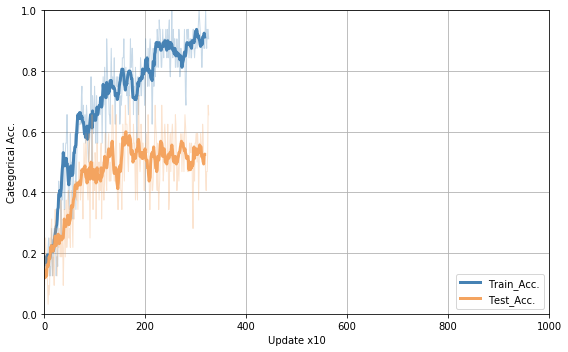

 33%|███▎      | 3284/10000 [03:50<07:50, 14.27it/s]

In [21]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.figure(figsize=(8,5))
plt.plot(running_mean(acc_train, 10),lw=3, c="steelblue", label="Train_Acc.")
plt.plot(running_mean(acc_train, 2),lw=1, c="steelblue", alpha=.3)
plt.plot(running_mean(acc_test, 10),lw=3, c="sandybrown",  label="Test_Acc.")
plt.plot(running_mean(acc_test, 2),lw=1, c="sandybrown", alpha=.3)
plt.xlabel("Update x10")
plt.ylabel("Categorical Acc.")
plt.grid()
plt.xlim(0,1000)
plt.ylim(0,1)
plt.legend(loc=4)

plt.tight_layout()

plt.savefig("urban_acc.png", dpi=200)